# Stock Prediction

This project introduces common techniques to manipulate time series and make predictions.

The data is a sample from the historical [NSE(National Stock Exchange) ](https://www.nseindia.com/products/content/equities/indices/historical_index_data.htm). Only a stock from NSE will be considered for analysis. 

There is roughly 1234 days of recoreded trading for the index.

In [5]:
import numpy as np
import pandas as pd #For data processing
import matplotlib.pyplot as plt #For data visualization
from nsepy import get_history
import datetime as dt

from statsmodels.tsa.stattools import acf, pacf
from scipy.ndimage.interpolation import shift
from statsmodels.tsa.arima_model import ARIMA


from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# from tickerstore.store import TickerStore

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# To show plot next to the code and not in a new window

## Exploratory Data Analysis

In [6]:
#DATAPATH = 'data/data2014-19.csv'
startYear = int(2014)
startMonth = int(11)
startDay = int(5)

endYear = int(2019)
endMonth = int(11)
endDay = int(4)

#tickerSymbol = "NIFTY"
tickerSymbol = "ADANIPORTS"

startDate = dt.date(startYear,startMonth,startDay)
endDate = dt.date(endYear,endMonth,endDay)

# fetcher = TickerStore()
# fetcher.historical_data("SBIN", date(2018,1,1), date(2018,1,30), TickerStore.INTERVAL_DAY_1)

data = get_history(symbol=tickerSymbol, start=startDate, end=endDate)

In [8]:
#data = pd.read_csv(DATAPATH)
ts = data.Close
data.tail(10)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-10-22,ADANIPORTS,EQ,421.70,421.50,428.85,417.10,420.60,420.75,423.79,2380735,1.008931e+14,36089,560445,0.2354
2019-10-23,ADANIPORTS,EQ,420.75,418.00,419.00,395.00,395.10,396.10,399.70,6752056,2.698781e+14,66672,1754932,0.2599
2019-10-24,ADANIPORTS,EQ,396.10,399.00,401.45,393.35,398.55,399.15,399.21,6433637,2.568375e+14,48660,2130282,0.3311
2019-10-25,ADANIPORTS,EQ,399.15,402.95,402.95,396.85,397.60,398.95,399.82,3272059,1.308220e+14,27005,1473825,0.4504
2019-10-27,ADANIPORTS,EQ,398.95,402.25,402.25,398.55,399.50,399.80,400.41,110114,4.409042e+12,2102,38034,0.3454
2019-10-29,ADANIPORTS,EQ,399.80,401.00,401.00,398.15,398.80,398.95,399.82,2269051,9.072220e+13,35195,1352503,0.5961
2019-10-30,ADANIPORTS,EQ,398.95,399.20,405.00,395.50,398.15,398.10,400.49,5590453,2.238918e+14,48437,2382285,0.4261
2019-10-31,ADANIPORTS,EQ,398.10,399.25,400.00,393.65,395.90,395.80,396.41,2529130,1.002566e+14,27803,1577945,0.6239
2019-11-01,ADANIPORTS,EQ,395.80,396.00,397.25,387.85,388.30,389.75,391.58,3665336,1.435262e+14,37071,2085262,0.5689


In [9]:
data.shape

(1234, 14)

In [10]:
data.dtypes

Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                  int64
Deliverable Volume      int64
%Deliverble           float64
dtype: object

In [11]:
# data.head()
ts.head()

Date
2014-11-05    288.75
2014-11-07    292.90
2014-11-10    290.70
2014-11-11    291.50
2014-11-12    300.70
Name: Close, dtype: float64

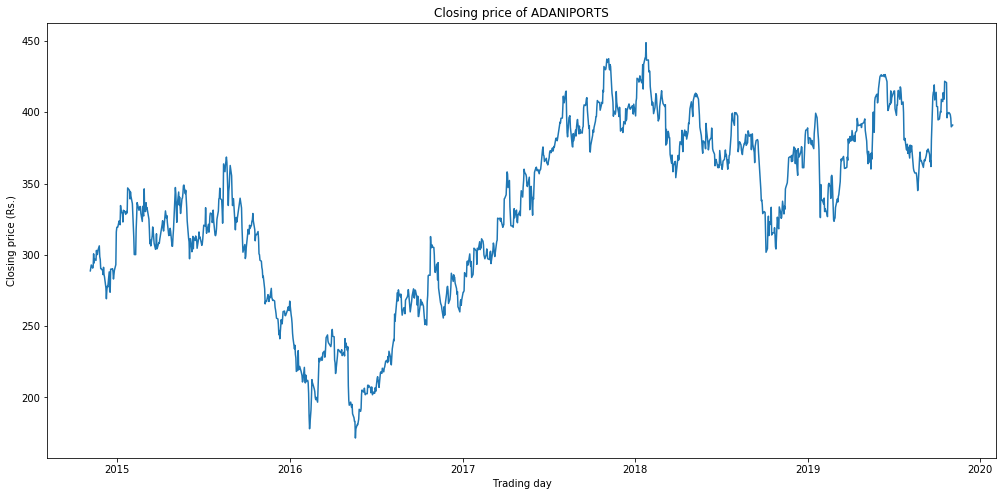

In [12]:
plt.figure(figsize=(17, 8))
plt.plot(ts)
plt.title('Closing price of '+ tickerSymbol)
plt.ylabel('Closing price (Rs.)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

### Moving average

In [13]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

In [14]:
# def test_stationarity(timeseries):
    
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(window=12).mean()
#     rolstd = timeseries.rolling(window=12).std()

#     #Plot rolling statistics:
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
#     #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)

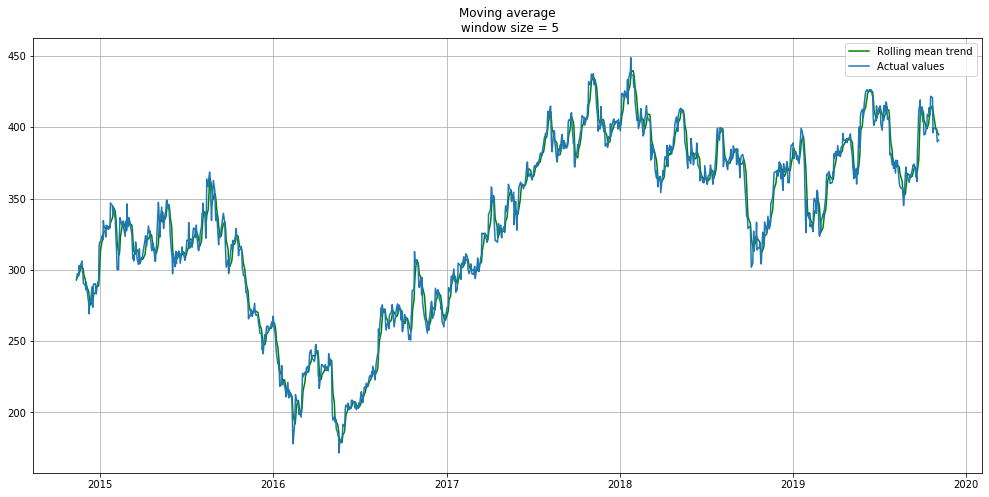

In [15]:
#Smooth by the previous 5 days (by week)
plot_moving_average(ts, 5)
#plot_moving_average(data.Close, 5,plot_intervals=True)

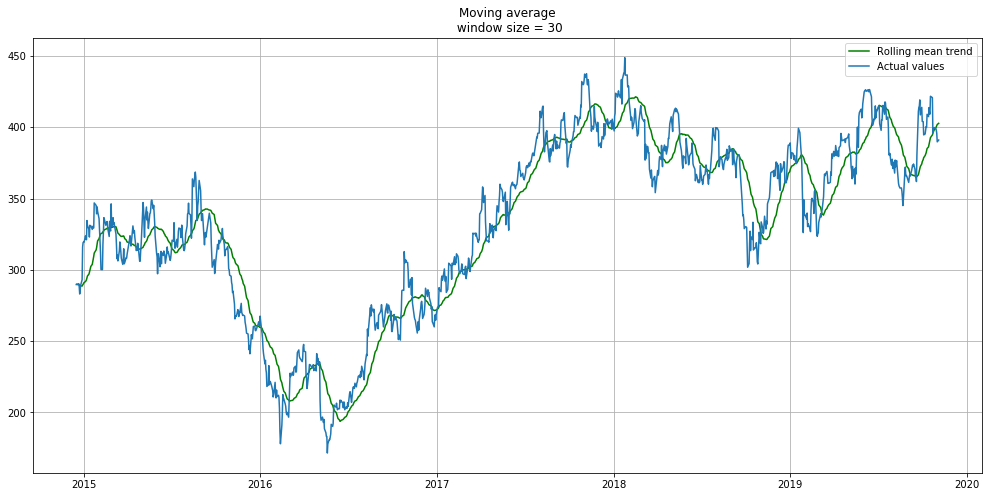

In [16]:
#Smooth by the previous month (30 days)
plot_moving_average(ts, 30)

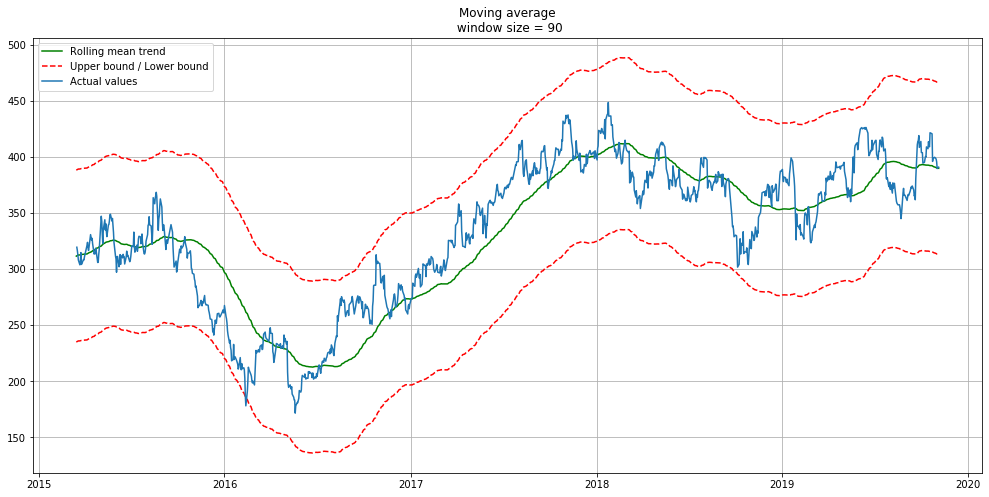

In [17]:
#Smooth by previous quarter (90 days)
plot_moving_average(ts, 90, plot_intervals=True)

### Exponential smoothing

In [18]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [19]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
  
    plt.title("Exponential Smoothing")
    plt.grid(True);

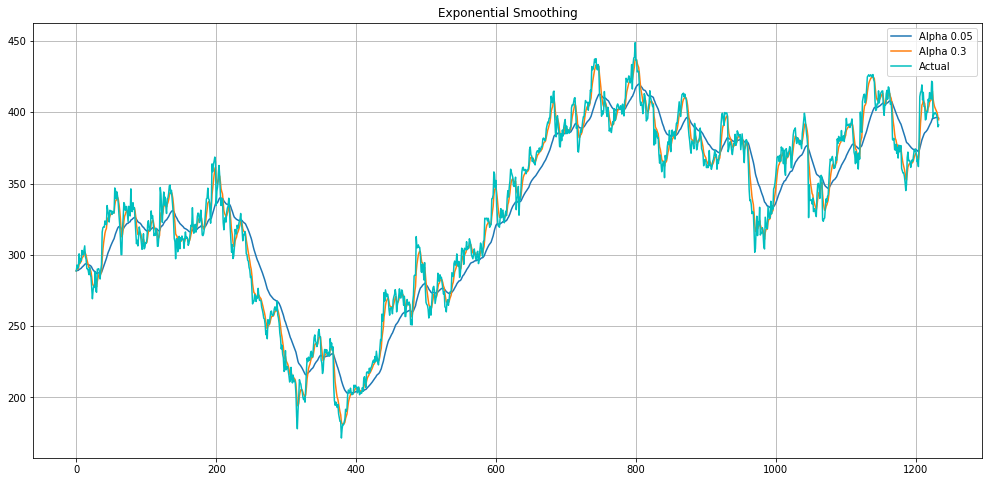

In [20]:
plot_exponential_smoothing(data.Close, [0.05,0.3])

### Double exponential smoothing 

In [22]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [23]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")

    plt.title("Double Exponential Smoothing")
    plt.grid(True)

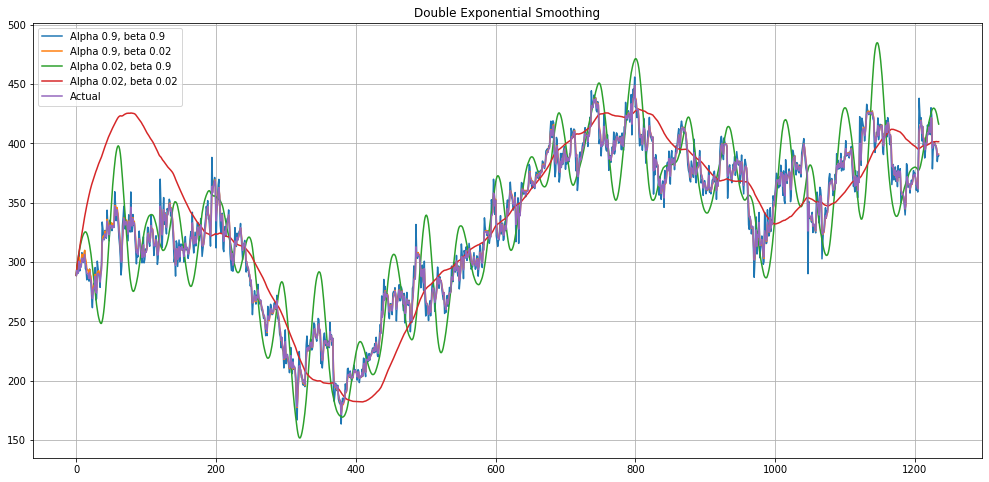

In [24]:
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Stationarity 

In [25]:
# def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
#     if not isinstance(y, pd.Series):
#         y = pd.Series(y)
        
#     with plt.style.context(style='bmh'):
#         fig = plt.figure(figsize=figsize)
#         layout = (2,2)
#         ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
#         acf_ax = plt.subplot2grid(layout, (1,0))
#         pacf_ax = plt.subplot2grid(layout, (1,1))
        
#         y.plot(ax=ts_ax)
#         p_value = sm.tsa.stattools.adfuller(y)[1]
#         ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
#         smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
#         smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
#         plt.tight_layout()

In [52]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

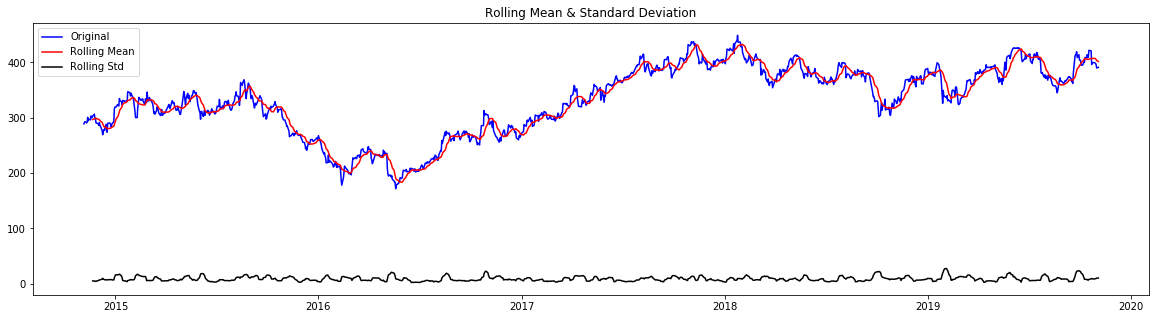

Results of Dickey-Fuller Test:
Test Statistic                   -1.830230
p-value                           0.365560
#Lags Used                        1.000000
Number of Observations Used    1232.000000
Critical Value (1%)              -3.435669
Critical Value (5%)              -2.863889
Critical Value (10%)             -2.568021
dtype: float64


In [53]:
test_stationarity(ts)

In [54]:
# import statsmodels.api as sm
# import statsmodels.tsa.api as smt
# tsplot(ts, lags=30)

In [55]:
# data_diff = ts - ts.shift(1)

In [56]:
# tsplot(data_diff[1:], lags=30)

In [80]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [89]:
differencedSeriesAsList = difference(ts)
differencedSeries = pd.Series(differencedSeriesAsList)

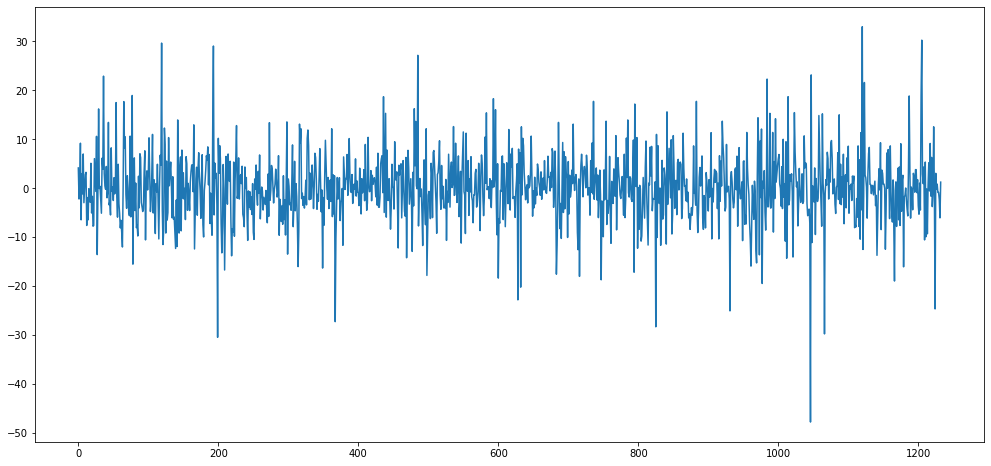

In [90]:
plt.figure(figsize=(17, 8))
plt.plot(differencedSeries)

In [91]:
dftest = adfuller(differencedSeriesAsList,autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags used','Number Of Observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test statistic                  -36.731006
p-value                           0.000000
#Lags used                        0.000000
Number Of Observations used    1232.000000
Critical Value (1%)              -3.435669
Critical Value (5%)              -2.863889
Critical Value (10%)             -2.568021
dtype: float64


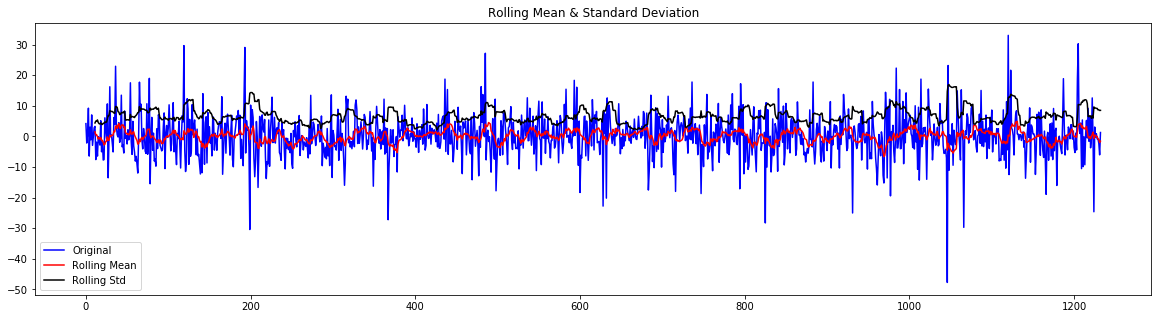

Results of Dickey-Fuller Test:
Test Statistic                  -36.731006
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1232.000000
Critical Value (1%)              -3.435669
Critical Value (5%)              -2.863889
Critical Value (10%)             -2.568021
dtype: float64


In [92]:
test_stationarity(differencedSeries)

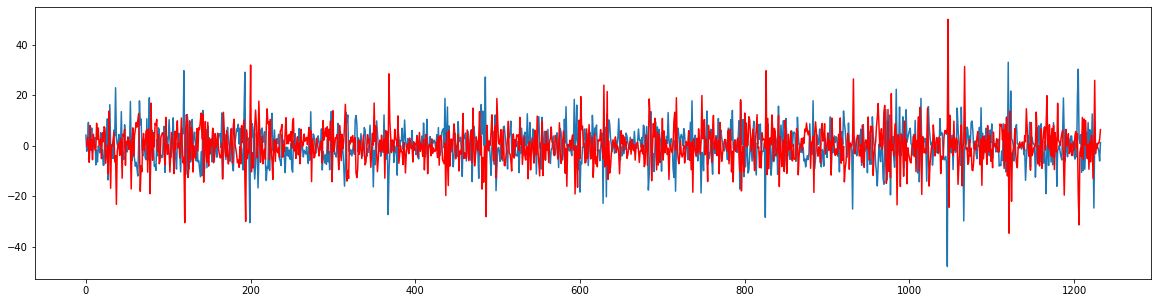

In [94]:
model = ARIMA(differencedSeries, order=(2,1,2))
results = model.fit(disp=-1)
plt.figure(figsize=(20,5))
plt.plot(differencedSeries)
plt.plot(results.fittedvalues, color='red')
# #Set initial values and some bounds
# ps = range(0, 5)
# d = 1
# qs = range(0, 5)
# Ps = range(0, 5)
# D = 1
# Qs = range(0, 5)
# s = 5

# #Create a list with all possible combinations of parameters
# from itertools import product
# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# len(parameters_list)

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_differencedSeries = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)

In [30]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    from tqdm import tqdm_notebook
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(ts, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [31]:
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(ts, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                 1234
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 5)   Log Likelihood               -4146.893
Date:                           Mon, 16 Dec 2019   AIC                           8299.787
Time:                                   15:05:47   BIC                           8315.126
Sample:                                        0   HQIC                          8305.559
                                          - 1234                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0455      0.024     -1.887      0.059      -0.093       0.002
ma.S.L5       -0.9995      0.125     -8.027

In [44]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
#plot_SARIMA(ts, best_model, 5)
print(best_model.predict(start=ts.shape[0], end=ts.shape[0] + 5))
print(mean_absolute_percentage_error(ts[s+d:], best_model.fittedvalues[s+d:]))

1234    391.415454
1235    391.186404
1236    391.441625
1237    391.378382
1238    391.369502
1239    391.829629
dtype: float64
1.582140048996619


In [41]:
numberOfDaysToBeCompared = 10 
#Note: Non- working days will be excluded automatically.
#Therefore, actual number of comparisons may be less than the number mentioned here.

newStartDate = endDate
newEndDate = newStartDate+ timedelta(days=numberOfDaysToBeCompared)

numberOfWorkingDays = np.busday_count( newStartDate, newEndDate )

actualData = get_history(symbol=tickerSymbol, start=newStartDate, end=newEndDate)
actualClosingPrice = actualData.Close

temp = best_model.predict(start=ts.shape[0], end=ts.shape[0] + numberOfWorkingDays)

predictedClosingPrice = []
for x in temp:
    predictedClosingPrice.append(x)

print(actualClosingPrice)
print(predictedClosingPrice)
print(newStartDate)
print(numberOfWorkingDays)


comparison = pd.DataFrame({'actual':actualClosingPrice,
                          'predicted': predictedClosingPrice},
                          index = pd.date_range(start=newStartDate, periods=numberOfWorkingDays,))

# comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
#                           'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]}, 
#                           index = pd.date_range(start='2018-06-05', periods='6',))

Date
2019-11-04    391.00
2019-11-05    390.00
2019-11-06    391.00
2019-11-07    390.45
2019-11-08    386.15
2019-11-11    387.90
2019-11-13    370.80
2019-11-14    369.10
Name: Close, dtype: float64
[391.4154542017348, 391.1864041608946, 391.44162543459623, 391.3783817228885, 391.3695017416999, 391.8296289113333, 391.60057887049305, 391.8558001441947, 391.7925564324869]
2019-11-04
8


ValueError: could not broadcast input array from shape (9) into shape (8)

In [ ]:
comparison.head()

No handles with labels found to put in legend.


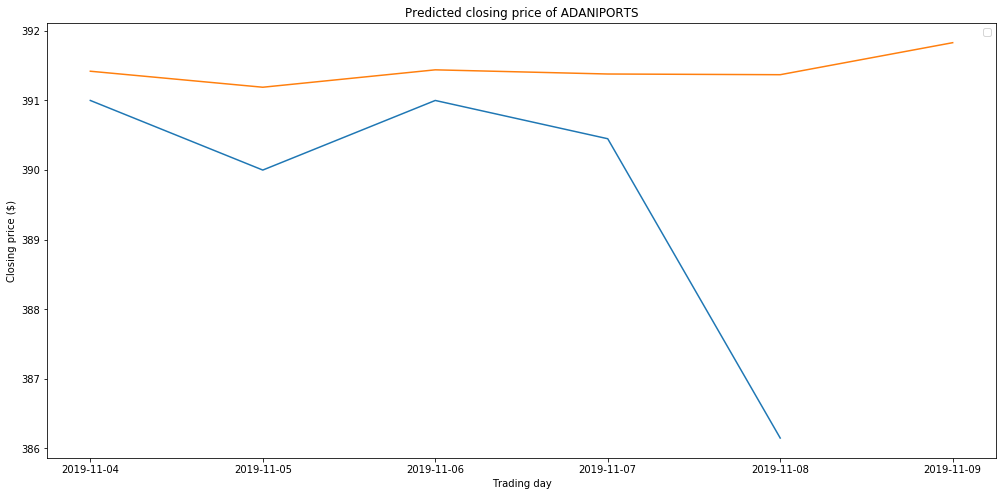

In [58]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted closing price of '+tickerSymbol)
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

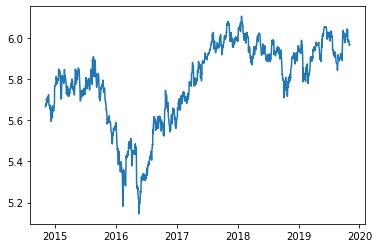

In [32]:
plt.plot(ts_log)

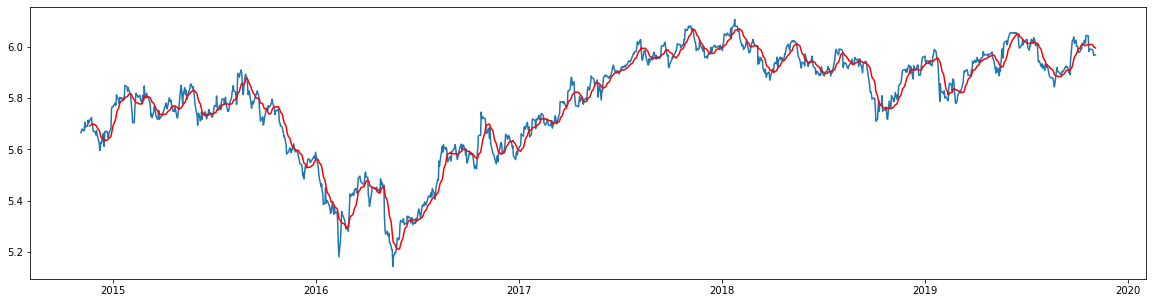

In [33]:
moving_avg = ts_log.rolling(12).mean()
plt.figure(figsize=(20,5))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

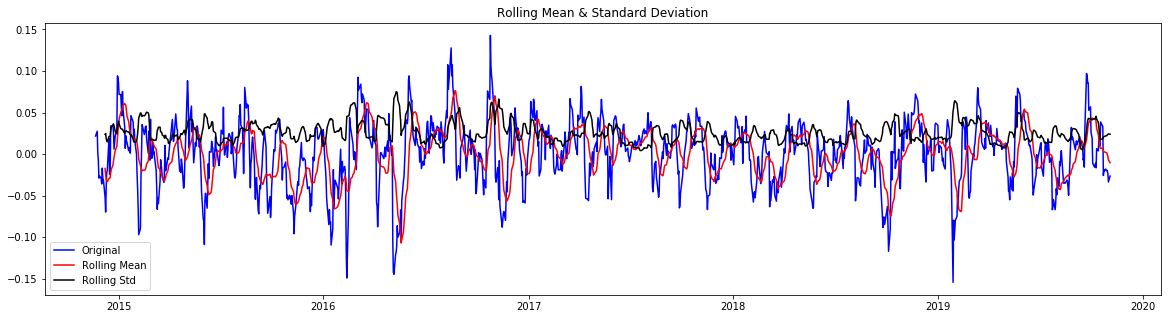

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [34]:
ts_log_moving_avg_diff = ts_log - moving_avg
test_stationarity(ts_log_moving_avg_diff)